# Comprehensive Grid Search for Logistic Regression & AdaBoost
## Testing All Imbalance Strategies + Hyperparameter Tuning
### Optimizing for Recall Score (Maximize Fraud Detection)

In [3]:
import pandas as pd

In [4]:
df =  pd.read_csv('../data/final_train_data.csv')

print( df.shape)

df.head()

(3787, 101)


,Provider,BeneID_get_mode_count,AttendingPhysician_get_mode_count,OperatingPhysician_nunique,OperatingPhysician_get_mode_count,OtherPhysician_get_mode_count,ClmAdmitDiagnosisCode_nunique,DiagnosisGroupCode_nunique,State_nunique,County_Name_nunique,...,State_Concentration,Diag_Concentration,GroupCode_Concentration,County_Concentration,Circulatory_Rate,IllDefined_Rate,MetabolicBlood_Rate,Musculoskeletal_Rate,Supplementary_Rate,PotentialFraud
0,PRV51001,2,5,5,1,2,8,6,1,7,...,1.000000,0.560000,0.8,0.240000,0.560000,0.560000,0.520000,0.080000,0.400000,0
1,PRV51004,4,16,19,4,10,13,1,9,30,...,0.503356,0.812081,1.0,0.147651,0.496644,0.382550,0.449664,0.194631,0.550336,0
2,PRV51013,2,22,5,5,7,6,1,2,9,...,0.652174,0.739130,1.0,0.304348,0.282609,0.456522,0.239130,0.239130,0.608696,0
3,PRV51014,3,7,6,3,4,5,1,2,6,...,0.866667,0.833333,1.0,0.400000,0.633333,0.400000,0.566667,0.200000,0.533333,0
4,PRV51015,2,4,1,1,1,1,1,1,3,...,1.000000,1.000000,1.0,0.625000,0.000000,0.500000,0.875000,0.250000,0.750000,0


## Step 1: Import All Required Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, 
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')


## Step 2: Prepare Data - Train/Test Split

In [6]:
# Separate features and target
X = df.drop('PotentialFraud', axis=1)
y = df['PotentialFraud']

print(f"Dataset shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"\nClass percentages:\n{y.value_counts(normalize=True) * 100}")

# Check for categorical/string columns
print(f"\nData types in features:")
print(X.dtypes.value_counts())

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
if len(non_numeric_cols) > 0:
    print(f"\n  Found {len(non_numeric_cols)} non-numeric columns:")
    for col in non_numeric_cols[:10]:  # Show first 10
        print(f"   • {col}: {X[col].nunique()} unique values")
    
    # Drop non-numeric columns (or encode them if needed)
    print(f"\n Removing non-numeric columns...")
    X = X.drop(columns=non_numeric_cols)
    print(f"   New feature count: {X.shape[1]}")

# Ensure all remaining columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Check for NaN values after conversion
if X.isnull().any().any():
    print(f"\n  Found NaN values, filling with 0...")
    X = X.fillna(0)

print(f"\n Final dataset shape: {X.shape}")
print(f" All features are numeric: {X.dtypes.unique()}")

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")
print(f"Train class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")

Dataset shape: (3787, 100)
Class distribution:
PotentialFraud
0    3433
1     354
Name: count, dtype: int64

Class percentages:
PotentialFraud
0    90.652231
1     9.347769
Name: proportion, dtype: float64

Data types in features:
float64    65
int64      34
object      1
Name: count, dtype: int64

  Found 1 non-numeric columns:
   • Provider: 3787 unique values

 Removing non-numeric columns...
   New feature count: 99

 Final dataset shape: (3787, 99)
 All features are numeric: [dtype('int64') dtype('float64')]

Train size: 3029
Test size: 758
Train class distribution: {0: 2746, 1: 283}
Test class distribution: {0: 687, 1: 71}


## Step 3: Define All Imbalance Handling Strategies

We'll test **8 different strategies**:
1. **No Resampling** (baseline with class_weight='balanced')
2. **SMOTE** (Synthetic Minority Oversampling)
3. **ADASYN** (Adaptive Synthetic Sampling)
4. **Random Oversampling**
5. **Random Undersampling**
6. **NearMiss** (Undersampling)
7. **SMOTE + Tomek Links** (Combined)
8. **SMOTE + ENN** (Combined)

In [8]:
# Define all imbalance strategies to test
imbalance_strategies = {
    'No_Resampling': None,
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'NearMiss': NearMiss(version=1),
    'SMOTETomek': SMOTETomek(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

print("Imbalance strategies defined:")
for strategy_name in imbalance_strategies.keys():
    print(f"   {strategy_name}")

Imbalance strategies defined:
   No_Resampling
   SMOTE
   ADASYN
   RandomOverSampler
   RandomUnderSampler
   NearMiss
   SMOTETomek
   SMOTEENN


## Step 4A: Logistic Regression Hyperparameter Grid

Testing Logistic Regression parameters:
- **Penalty**: L1, L2
- **C** (regularization strength): Multiple values
- **Solver**: Compatible solvers
- **Class Weight**: balanced and custom ratios
- **Max Iterations**: Ensure convergence

In [14]:
#  LOGISTIC REGRESSION - Hyperparameter Grid
lr_param_grid = {
    # Regularization penalty
    'penalty': ['l2', 'l1'],  # Reduced from 4 to 2 (most common)
    
    # Regularization strength (key values only)
    'C': [0.01, 0.1, 1.0, 10.0],  # Reduced from 12 to 4 (covers wide range)
    
    # Solver algorithms - only compatible ones
    'solver': ['saga', 'liblinear'],  # Reduced from 5 to 2 (most versatile)
    
    # Class weighting strategies
    'class_weight': ['balanced', {0: 1, 1: 10}, None],  # Reduced from 5 to 3
    
    # Maximum iterations for convergence
    'max_iter': [1000],  # Reduced from 3 to 1 (usually sufficient)
}

print(" LOGISTIC REGRESSION - HYPERPARAMETER GRID ")
print("="*60)
print(f"  • Penalties: {len(lr_param_grid['penalty'])} options")
print(f"  • C values: {len(lr_param_grid['C'])} options")
print(f"  • Solvers: {len(lr_param_grid['solver'])} options")
print(f"  • Class weights: {len(lr_param_grid['class_weight'])} options")
print(f"  • Max iterations: {len(lr_param_grid['max_iter'])} options")

lr_total = (len(lr_param_grid['penalty']) * len(lr_param_grid['C']) * 
            len(lr_param_grid['solver']) * len(lr_param_grid['class_weight']) *
            len(lr_param_grid['max_iter']))
print(f"\n Total LR combinations per strategy: {lr_total}")
print("="*60)

 LOGISTIC REGRESSION - HYPERPARAMETER GRID 
  • Penalties: 2 options
  • C values: 4 options
  • Solvers: 2 options
  • Class weights: 3 options
  • Max iterations: 1 options

 Total LR combinations per strategy: 48


## Step 4B: AdaBoost Hyperparameter Grid

Testing AdaBoost parameters:
- **n_estimators**: Number of boosting iterations
- **learning_rate**: Shrinks contribution of each classifier
- **algorithm**: SAMME or SAMME.R
- **Base estimator**: Decision tree with different max_depth

In [13]:
#  ADABOOST - Hyperparameter Grid
ada_param_grid = {
    # Number of boosting stages
    'n_estimators': [50, 100, 200],
    
    # Learning rate (weight applied to each classifier)
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    
    # Boosting algorithm
    'algorithm': ['SAMME', 'SAMME.R'],
}

# Base estimator options (different decision tree depths)
base_estimators = [
    DecisionTreeClassifier(max_depth=1, random_state=42),  # Stump
    DecisionTreeClassifier(max_depth=3, random_state=42),  # Shallow tree
    DecisionTreeClassifier(max_depth=5, random_state=42),  # Medium tree
]

print(" ADABOOST - HYPERPARAMETER GRID ")
print("="*60)
print(f"  • n_estimators: {len(ada_param_grid['n_estimators'])} options")
print(f"  • Learning rates: {len(ada_param_grid['learning_rate'])} options")
print(f"  • Algorithms: {len(ada_param_grid['algorithm'])} options")
print(f"  • Base estimators: {len(base_estimators)} options (max_depth 1, 3, 5)")

ada_total = (len(ada_param_grid['n_estimators']) * 
             len(ada_param_grid['learning_rate']) *
             len(ada_param_grid['algorithm']) *
             len(base_estimators))
print(f"\n Total AdaBoost combinations per strategy: {ada_total}")
print("="*60)

print(f"\n TOTAL COMBINATIONS:")
print(f"   Logistic Regression: {lr_total} × 8 strategies = {lr_total * 8}")
print(f"   AdaBoost:            {ada_total} × 8 strategies = {ada_total * 8}")
print(f"   GRAND TOTAL:         {(lr_total + ada_total) * 8} model fits")
print(f"   With 5-fold CV:      ~{(lr_total + ada_total) * 8 * 5} trainings")
print(f"\n")

 ADABOOST - HYPERPARAMETER GRID 
  • n_estimators: 3 options
  • Learning rates: 4 options
  • Algorithms: 2 options
  • Base estimators: 3 options (max_depth 1, 3, 5)

 Total AdaBoost combinations per strategy: 72

 TOTAL COMBINATIONS:
   Logistic Regression: 48 × 8 strategies = 384
   AdaBoost:            72 × 8 strategies = 576
   GRAND TOTAL:         960 model fits
   With 5-fold CV:      ~4800 trainings




## Step 5: Grid Search for Each Imbalance Strategy

For each imbalance strategy, we'll:
1. Apply the resampling technique (or use class weighting)
2. Test BOTH Logistic Regression AND AdaBoost
3. Run GridSearchCV with 5-fold cross-validation
4. Optimize for **Recall Score** (Maximize Fraud Detection)
5. Track the best model, parameters, and performance for each

In [8]:
import time
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Storage for results
all_results = []
best_models = {}
print("new")
# Recall scorer for GridSearchCV - MAXIMIZE FRAUD DETECTION
recall_scorer = make_scorer(recall_score, zero_division=0)

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("="*80)
print("STARTING COMPREHENSIVE GRID SEARCH")
print("="*80)
print(f"Models: Logistic Regression & AdaBoost")
print(f"Optimization Metric: RECALL SCORE (Maximize Fraud Detection)")
print(f"Cross-Validation: 5-Fold Stratified")
print(f"Total Strategies to Test: {len(imbalance_strategies)}")
print("="*80 + "\n")

# Models to test
models_config = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(random_state=42, warm_start=False),
        'param_grid': lr_param_grid,
        'needs_scaling': True
    },
    {
        'name': 'AdaBoost',
        'model': None,  # Will iterate through base estimators
        'param_grid': ada_param_grid,
        'base_estimators': base_estimators,
        'needs_scaling': False  # AdaBoost doesn't require scaling
    }
]

for strategy_name, sampler in imbalance_strategies.items():
    print(f"\n{'='*80}")
    print(f"TESTING STRATEGY: {strategy_name}")
    print(f"{'='*80}")
    
    # Apply resampling if not using class weighting only
    if sampler is not None:
        print(f"Applying {strategy_name} resampling...")
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
        print(f"  Original training size: {X_train.shape[0]}")
        print(f"  Resampled training size: {X_train_resampled.shape[0]}")
        print(f"  Class distribution: {pd.Series(y_train_resampled).value_counts().to_dict()}")
    else:
        print(f"Using original training data (will rely on class_weight parameter)")
        X_train_resampled = X_train
        y_train_resampled = y_train
    
    # Test each model type
    for model_config in models_config:
        model_name = model_config['name']
        print(f"\n{'-'*80}")
        print(f"  MODEL: {model_name}")
        print(f"{'-'*80}")
        
        start_time = time.time()
        
        # Prepare data
        if model_config['needs_scaling']:
            scaler = StandardScaler()
            X_train_processed = scaler.fit_transform(X_train_resampled)
            X_test_processed = scaler.transform(X_test)
        else:
            scaler = None
            X_train_processed = X_train_resampled
            X_test_processed = X_test
        
        # Handle AdaBoost base estimators
        if model_name == 'AdaBoost':
            best_score = -1
            best_model_overall = None
            best_params_overall = None
            
            for base_est in model_config['base_estimators']:
                ada_model = AdaBoostClassifier(estimator=base_est, random_state=42)
                
                grid_search = GridSearchCV(
                    estimator=ada_model,
                    param_grid=model_config['param_grid'],
                    scoring=recall_scorer,
                    cv=cv_strategy,
                    n_jobs=-1,
                    verbose=0,
                    error_score=0
                )
                
                grid_search.fit(X_train_processed, y_train_resampled)
                
                if grid_search.best_score_ > best_score:
                    best_score = grid_search.best_score_
                    best_model_overall = grid_search.best_estimator_
                    best_params_overall = grid_search.best_params_.copy()
                    best_params_overall['base_estimator_max_depth'] = base_est.max_depth
            
            best_model = best_model_overall
            best_params = best_params_overall
            best_cv_recall = best_score
        else:
            # Logistic Regression
            print(f"  Running GridSearchCV...")
            grid_search = GridSearchCV(
                estimator=model_config['model'],
                param_grid=model_config['param_grid'],
                scoring=recall_scorer,
                cv=cv_strategy,
                n_jobs=-1,
                verbose=0,
                error_score=0
            )
            
            grid_search.fit(X_train_processed, y_train_resampled)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_cv_recall = grid_search.best_score_
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test_processed)
        y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
        
        # Calculate all metrics
        test_precision = precision_score(y_test, y_pred, zero_division=0)
        test_recall = recall_score(y_test, y_pred, zero_division=0)
        test_f1 = f1_score(y_test, y_pred, zero_division=0)
        test_roc_auc = roc_auc_score(y_test, y_pred_proba)
        test_pr_auc = average_precision_score(y_test, y_pred_proba)
        
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        elapsed_time = time.time() - start_time
        
        # Store results
        result = {
            'Strategy': strategy_name,
            'Model': model_name,
            'Best_CV_Recall': best_cv_recall,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_F1': test_f1,
            'Test_ROC_AUC': test_roc_auc,
            'Test_PR_AUC': test_pr_auc,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp,
            'Training_Time_Sec': elapsed_time,
            'Best_Params': best_params
        }
        all_results.append(result)
        best_models[f"{strategy_name}_{model_name}"] = {
            'model': best_model,
            'scaler': scaler,
            'params': best_params
        }
        
        # Print results
        print(f"  Best CV Recall:        {best_cv_recall:.4f}")
        print(f"  Test Set Precision:    {test_precision:.4f}")
        print(f"  Test Set Recall:       {test_recall:.4f}")
        print(f"  Test Set F1-Score:     {test_f1:.4f}")
        print(f"  Test Set ROC-AUC:      {test_roc_auc:.4f}")
        print(f"  Test Set PR-AUC:       {test_pr_auc:.4f}")
        print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
        print(f"  Training Time:         {elapsed_time:.2f}s")

print("\n" + "="*80)
print("GRID SEARCH COMPLETE!")
print("="*80)

new
STARTING COMPREHENSIVE GRID SEARCH
Models: Logistic Regression & AdaBoost
Optimization Metric: RECALL SCORE (Maximize Fraud Detection)
Cross-Validation: 5-Fold Stratified
Total Strategies to Test: 8


TESTING STRATEGY: No_Resampling
Using original training data (will rely on class_weight parameter)

--------------------------------------------------------------------------------
  MODEL: LogisticRegression
--------------------------------------------------------------------------------
  Running GridSearchCV...
  Best CV Recall:        0.9080
  Test Set Precision:    0.3846
  Test Set Recall:       0.9155
  Test Set F1-Score:     0.5417
  Test Set ROC-AUC:      0.9461
  Test Set PR-AUC:       0.7113
  Confusion Matrix: TN=583, FP=104, FN=6, TP=65
  Training Time:         24.68s

--------------------------------------------------------------------------------
  MODEL: AdaBoost
--------------------------------------------------------------------------------
  Best CV Recall:        0

## Step 6: Compare All Strategies - Find the Best Model

In [17]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)

# Sort by Test Precision (our optimization metric)
results_df = results_df.sort_values('Test_Precision', ascending=False)

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON - ALL STRATEGIES")
print("="*80)
print("\nRanked by Test Set Precision Score:")
print(results_df[['Strategy', 'Test_Precision', 'Test_Recall', 'Test_F1', 
                   'Test_PR_AUC', 'Test_ROC_AUC']].to_string(index=False))

print("\n" + "="*80)
print("WINNER: BEST MODEL BY PRECISION")
print("="*80)
best_strategy = results_df.iloc[0]
print(f"\n Best Strategy: {best_strategy['Strategy']}")
print(f"   Test Precision:  {best_strategy['Test_Precision']:.4f}")
print(f"   Test Recall:     {best_strategy['Test_Recall']:.4f}")
print(f"   Test F1-Score:   {best_strategy['Test_F1']:.4f}")
print(f"   Test PR-AUC:     {best_strategy['Test_PR_AUC']:.4f}")
print(f"   Test ROC-AUC:    {best_strategy['Test_ROC_AUC']:.4f}")

print(f"\n Confusion Matrix:")
print(f"   TN: {int(best_strategy['TN']):4d}  |  FP: {int(best_strategy['FP']):4d}")
print(f"   FN: {int(best_strategy['FN']):4d}  |  TP: {int(best_strategy['TP']):4d}")

print(f"\n  Best Hyperparameters:")
for param, value in best_strategy['Best_Params'].items():
    print(f"   {param}: {value}")

print(f"\n  Training Time: {best_strategy['Training_Time_Sec']:.2f} seconds")
print("="*80)


COMPREHENSIVE COMPARISON - ALL STRATEGIES

Ranked by Test Set Precision Score:
          Strategy  Test_Precision  Test_Recall  Test_F1  Test_PR_AUC  Test_ROC_AUC
     No_Resampling        0.720930     0.436620 0.543860     0.553685      0.888349
            ADASYN        0.666667     0.563380 0.610687     0.639895      0.939808
        SMOTETomek        0.666667     0.535211 0.593750     0.671151      0.947065
             SMOTE        0.622951     0.535211 0.575758     0.664500      0.949402
 RandomOverSampler        0.592105     0.633803 0.612245     0.609903      0.937532
          SMOTEENN        0.527273     0.816901 0.640884     0.682014      0.947762
RandomUnderSampler        0.460993     0.915493 0.613208     0.667663      0.952765
     No_Resampling        0.384615     0.915493 0.541667     0.711329      0.946143
          NearMiss        0.325581     0.788732 0.460905     0.509440      0.898251
          SMOTEENN        0.267717     0.957746 0.418462     0.612407      0.925

## Step 7: Visualize Strategy Comparison

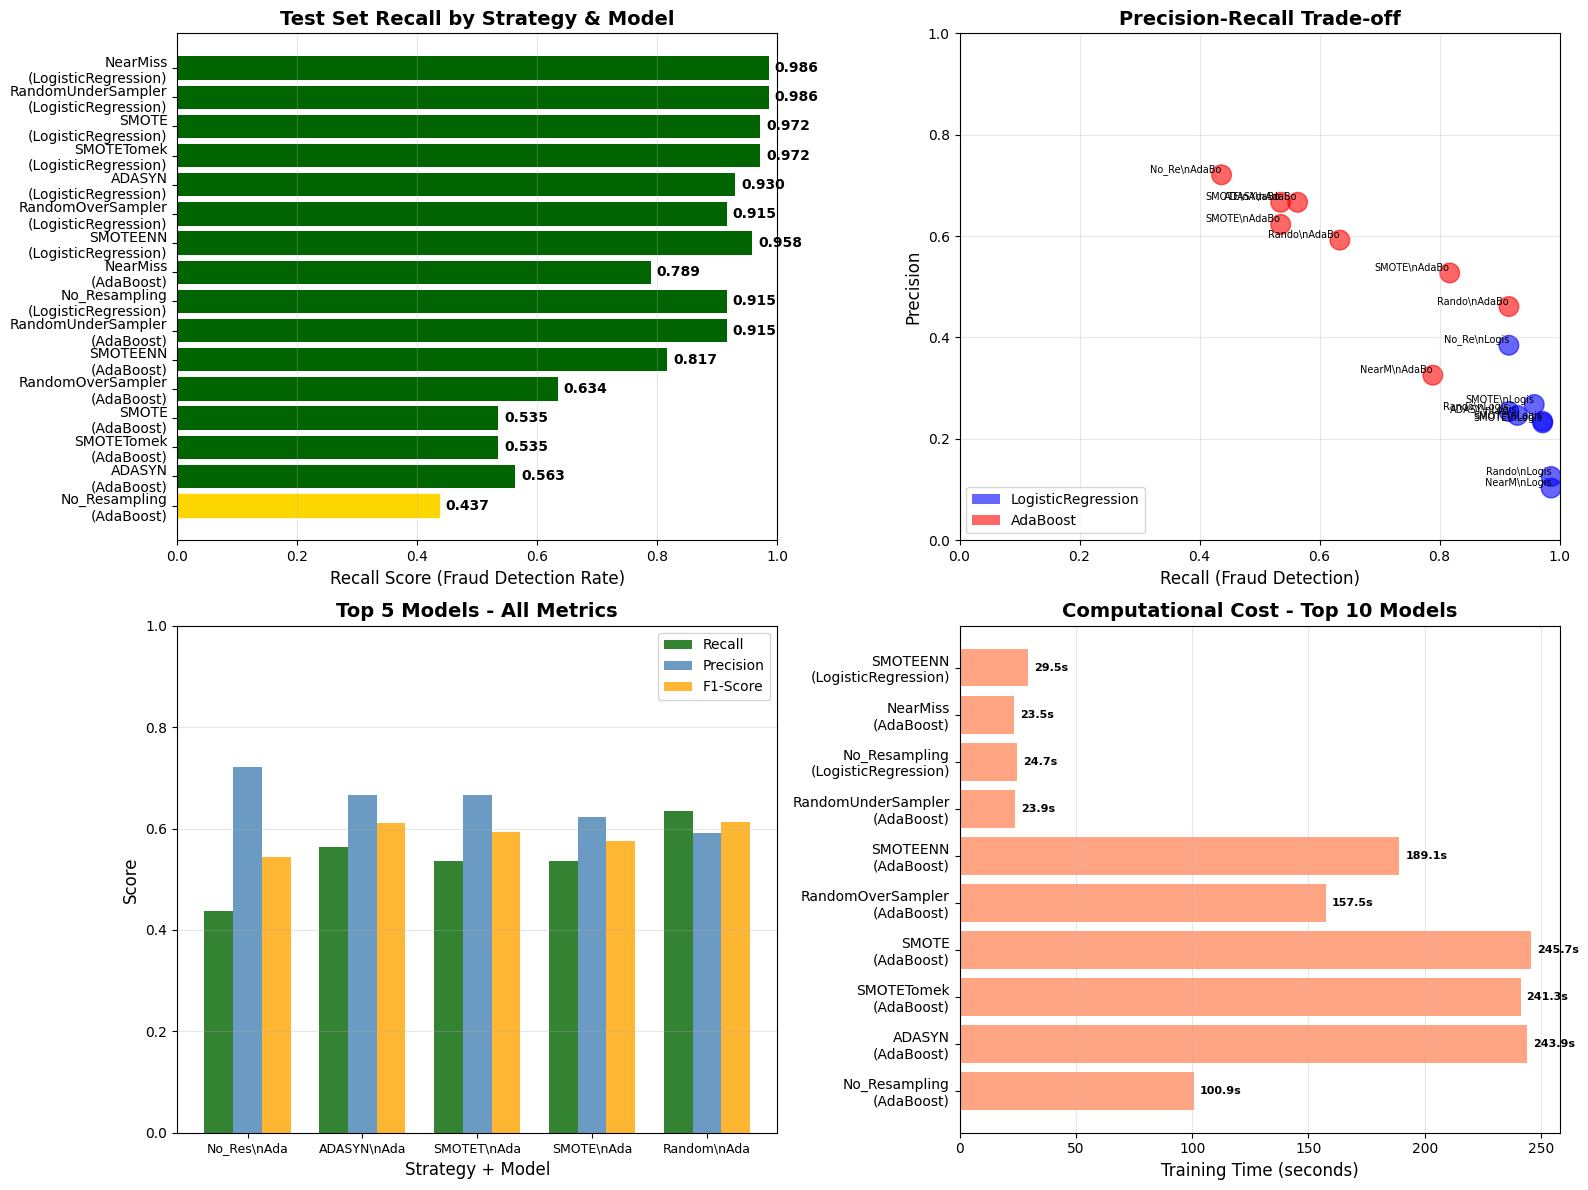

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create combined labels for strategy + model
results_df['Combined_Label'] = results_df['Strategy'] + '\n(' + results_df['Model'] + ')'

# 1. Recall Comparison (our optimization metric)
ax1 = axes[0, 0]
bars = ax1.barh(results_df['Combined_Label'], results_df['Test_Recall'], color='darkgreen')
ax1.set_xlabel('Recall Score (Fraud Detection Rate)', fontsize=12)
ax1.set_title('Test Set Recall by Strategy & Model', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)
# Highlight best
bars[0].set_color('gold')
for i, v in enumerate(results_df['Test_Recall']):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

# 2. Precision vs Recall Scatter
ax2 = axes[0, 1]
# Color by model type
colors = results_df['Model'].map({'LogisticRegression': 'blue', 'AdaBoost': 'red'})
scatter = ax2.scatter(results_df['Test_Recall'], results_df['Test_Precision'], 
                      s=200, alpha=0.6, c=colors)
for idx, row in results_df.iterrows():
    label = f"{row['Strategy'][:5]}\\n{row['Model'][:5]}"
    ax2.annotate(label, 
                 (row['Test_Recall'], row['Test_Precision']),
                 fontsize=7, ha='right', va='bottom')
ax2.set_xlabel('Recall (Fraud Detection)', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
# Add legend for models
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.6, label='LogisticRegression'),
                   Patch(facecolor='red', alpha=0.6, label='AdaBoost')]
ax2.legend(handles=legend_elements, loc='lower left')

# 3. All Metrics Comparison - Top 5
ax3 = axes[1, 0]
top5 = results_df.head(5).copy()
top5['Label'] = top5['Strategy'].str[:6] + '\\n' + top5['Model'].str[:3]
x = np.arange(len(top5))
width = 0.25
ax3.bar(x - width, top5['Test_Recall'], width, label='Recall', alpha=0.8, color='darkgreen')
ax3.bar(x, top5['Test_Precision'], width, label='Precision', alpha=0.8, color='steelblue')
ax3.bar(x + width, top5['Test_F1'], width, label='F1-Score', alpha=0.8, color='orange')
ax3.set_xlabel('Strategy + Model', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Top 5 Models - All Metrics', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(top5['Label'], rotation=0, ha='center', fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])

# 4. Training Time Comparison - Top 10
ax4 = axes[1, 1]
top10 = results_df.head(10)
ax4.barh(top10['Combined_Label'], top10['Training_Time_Sec'], color='coral', alpha=0.7)
ax4.set_xlabel('Training Time (seconds)', fontsize=12)
ax4.set_title('Computational Cost - Top 10 Models', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
for i, v in enumerate(top10['Training_Time_Sec']):
    ax4.text(v + max(top10['Training_Time_Sec'])*0.01, i, 
             f'{v:.1f}s', va='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

## Step 8: Detailed Evaluation of Best Model

In [15]:
# Get the best model - extract both Strategy and Model from results
best_row = results_df.iloc[0]
best_strategy_name = best_row['Strategy']
best_model_name = best_row['Model']

# Use combined key to access best_models dictionary
best_key = f"{best_strategy_name}_{best_model_name}"
best_model_info = best_models[best_key]
best_model = best_model_info['model']
best_scaler = best_model_info['scaler']

# Make predictions - handle None scaler for AdaBoost
if best_scaler is not None:
    y_pred = best_model.predict(best_scaler.transform(X_test))
    y_pred_proba = best_model.predict_proba(best_scaler.transform(X_test))[:, 1]
else:
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("="*80)
print(f"DETAILED EVALUATION: {best_strategy_name} + {best_model_name}")
print("="*80)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix Analysis:")
tn, fp, fn, tp = cm.ravel()
print(f"  True Negatives:  {tn:4d} (Correctly identified legitimate)")
print(f"  False Positives: {fp:4d} (Legitimate flagged as fraud - Type I Error)")
print(f"  False Negatives: {fn:4d} (Fraud missed - Type II Error)")
print(f"  True Positives:  {tp:4d} (Correctly identified fraud)")

# Business Metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"\nBusiness Metrics:")
print(f"  Sensitivity (Recall):     {sensitivity:.4f} ({sensitivity*100:.2f}% of frauds caught)")
print(f"  Specificity:              {specificity:.4f} ({specificity*100:.2f}% of legitimate correctly identified)")
print(f"  False Positive Rate:      {fpr:.4f} ({fpr*100:.2f}% of legitimate flagged)")
print(f"  False Negative Rate:      {fnr:.4f} ({fnr*100:.2f}% of frauds missed)")

# Feature Importance - handle both Logistic Regression and AdaBoost
if hasattr(best_model, 'coef_'):
    # Logistic Regression - coefficients
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\n" + "="*80)
    print("TOP 15 MOST IMPORTANT FEATURES (by absolute coefficient)")
    print("="*80)
    print(feature_importance.head(15).to_string(index=False))
elif hasattr(best_model, 'feature_importances_'):
    # AdaBoost - feature importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "="*80)
    print("TOP 15 MOST IMPORTANT FEATURES (by importance)")
    print("="*80)
    print(feature_importance.head(15).to_string(index=False))

DETAILED EVALUATION: No_Resampling + AdaBoost

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.94      0.98      0.96       687
  Fraudulent       0.72      0.44      0.54        71

    accuracy                           0.93       758
   macro avg       0.83      0.71      0.75       758
weighted avg       0.92      0.93      0.92       758


Confusion Matrix Analysis:
  True Negatives:   675 (Correctly identified legitimate)
  False Positives:   12 (Legitimate flagged as fraud - Type I Error)
  False Negatives:   40 (Fraud missed - Type II Error)
  True Positives:    31 (Correctly identified fraud)

Business Metrics:
  Sensitivity (Recall):     0.4366 (43.66% of frauds caught)
  Specificity:              0.9825 (98.25% of legitimate correctly identified)
  False Positive Rate:      0.0175 (1.75% of legitimate flagged)
  False Negative Rate:      0.5634 (56.34% of frauds missed)

TOP 15 MOST IMPORTANT FEATURES (by importance)
       

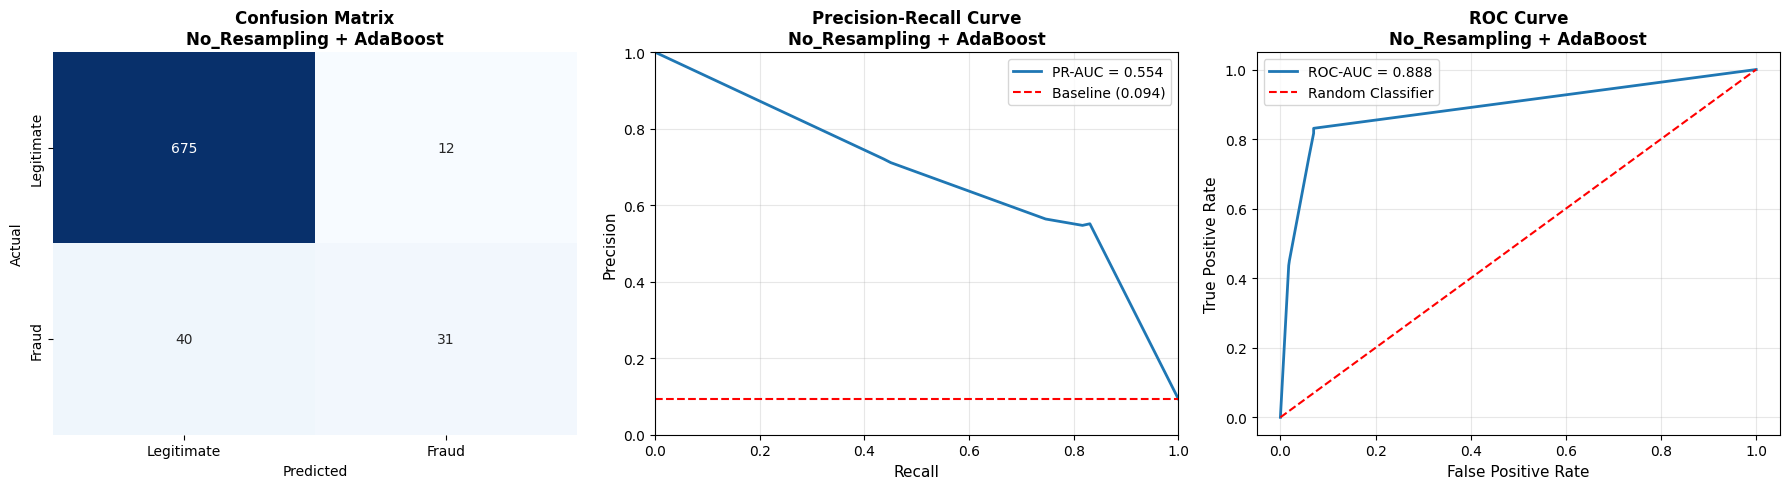

In [16]:
# Visualize Best Model Performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix Heatmap
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'], ax=ax1)
ax1.set_title(f'Confusion Matrix\n{best_strategy_name} + {best_model_name}', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# 2. Precision-Recall Curve
ax2 = axes[1]
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
ax2.plot(recall_vals, precision_vals, linewidth=2, label=f'PR-AUC = {pr_auc:.3f}')
ax2.axhline(y=y_test.sum()/len(y_test), color='r', linestyle='--', 
            label=f'Baseline ({y_test.sum()/len(y_test):.3f})')
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title(f'Precision-Recall Curve\n{best_strategy_name} + {best_model_name}', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

# 3. ROC Curve
ax3 = axes[2]
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
ax3.plot(fpr_vals, tpr_vals, linewidth=2, label=f'ROC-AUC = {roc_auc:.3f}')
ax3.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title(f'ROC Curve\n{best_strategy_name} + {best_model_name}', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()